In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Load the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')

# Cek 5 baris pertama untuk melihat struktur data
print(df.head())

# Cek apakah ada nilai yang hilang
print(df.isnull().sum())

# Cek distribusi data setelah preprocessing
print(df.describe())


   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
                 age  hypertension  heart_disea

Data setelah menghapus outliers manual: 75041 rows


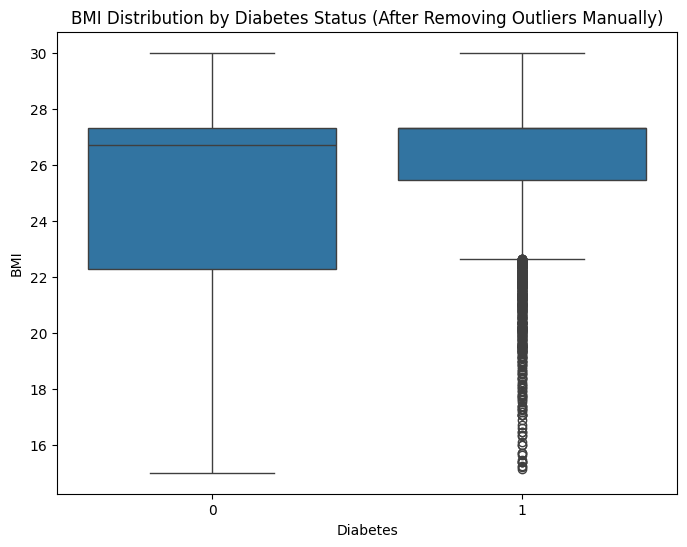

Original data: 100000 rows
Data after removing outliers using Isolation Forest: 75041 rows


In [2]:
# Menghapus NaN atau nilai kosong di kolom 'bmi'
df = df.dropna(subset=['bmi'])

# Tentukan threshold manual untuk kolom bmi
threshold_lower = 15  # Nilai BMI bawah yang realistis
threshold_upper = 30  # Nilai BMI atas yang realistis

# Hapus data yang berada di luar threshold ini
df_no_outliers_manual = df[(df['bmi'] >= threshold_lower) & (df['bmi'] <= threshold_upper)]

# Verifikasi data setelah penghapusan
print(f"Data setelah menghapus outliers manual: {len(df_no_outliers_manual)} rows")

# Visualisasi distribusi setelah penghapusan outliers manual
plt.figure(figsize=(8, 6))
sns.boxplot(x='diabetes', y='bmi', data=df_no_outliers_manual)
plt.title('BMI Distribution by Diabetes Status (After Removing Outliers Manually)')
plt.xlabel('Diabetes')
plt.ylabel('BMI')
plt.show()


print(f"Original data: {len(df)} rows")
print(f"Data after removing outliers using Isolation Forest: {len(df_no_outliers_manual)} rows")


In [3]:
# One-Hot Encoding untuk kolom kategorikal
df_encoded = pd.get_dummies(df_no_outliers_manual, drop_first=True)  # drop_first=True untuk menghindari dummy variable trap

# Menghapus kolom yang tidak diinginkan
drop_columns = ['smoking_history_current', 'smoking_history_not current', 'smoking_history_former']
drop_columns = [col for col in drop_columns if col in df_encoded.columns]  # Pastikan kolom ada sebelum dihapus
df_encoded = df_encoded.drop(columns=drop_columns)

# Menentukan fitur dan target
X = df_encoded.drop('diabetes', axis=1)  # Semua kolom selain 'diabetes' sebagai fitur
y = df_encoded['diabetes']  # Kolom 'diabetes' sebagai target

# Membagi data menjadi training set dan testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Melatih model Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gbm_model = GradientBoostingClassifier()

# Fit the GBM model to the training data
gbm_model.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = gbm_model.predict(X_train)


In [4]:
# Melihat distribusi kelas 0 dan 1 pada kolom 'diabetes'
print("Distribusi kelas diabetes:")
print(y.value_counts())


Distribusi kelas diabetes:
diabetes
0    70786
1     4255
Name: count, dtype: int64


Distribusi kelas setelah SMOTE:
diabetes
0    49569
1    49569
Name: count, dtype: int64


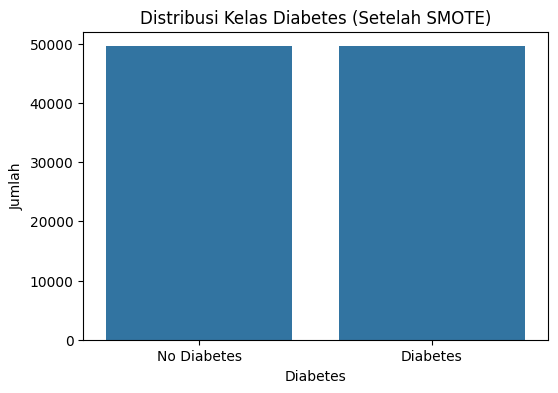

In [5]:
from imblearn.over_sampling import SMOTE

# Melakukan SMOTE pada data latih
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Memeriksa distribusi kelas setelah SMOTE
print("Distribusi kelas setelah SMOTE:")
print(y_train_res.value_counts())

# Visualisasi distribusi kelas setelah SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_res)
plt.title('Distribusi Kelas Diabetes (Setelah SMOTE)')
plt.xlabel('Diabetes')
plt.ylabel('Jumlah')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])
plt.show()


Hasil Evaluasi pada Data Latih:
Accuracy: 0.97
Precision: 0.98
Recall: 0.96
F1-Score: 0.97

Hasil Evaluasi pada Data Uji:
Accuracy: 0.97
Precision: 0.70
Recall: 0.74
F1-Score: 0.72


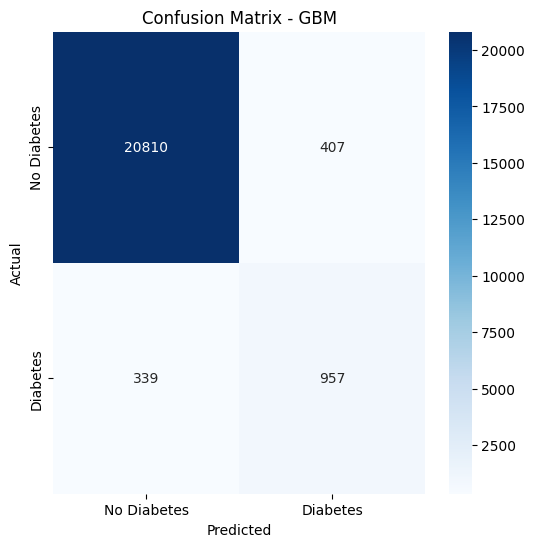

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.98      0.98      0.98     21217
    Diabetes       0.70      0.74      0.72      1296

    accuracy                           0.97     22513
   macro avg       0.84      0.86      0.85     22513
weighted avg       0.97      0.97      0.97     22513



In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Melatih model GBM
gbm_model = GradientBoostingClassifier(random_state=42)  # Pastikan random_state diatur agar hasil konsisten
gbm_model.fit(X_train_res, y_train_res)

# Prediksi pada data latih
y_pred_train = gbm_model.predict(X_train_res)

# Prediksi pada data uji
y_pred_test = gbm_model.predict(X_test)


# Evaluasi pada data latih
accuracy_train = accuracy_score(y_train_res, y_pred_train)
precision_train = precision_score(y_train_res, y_pred_train)
recall_train = recall_score(y_train_res, y_pred_train)
f1_train = f1_score(y_train_res, y_pred_train)

# Evaluasi pada data uji
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

# Menampilkan hasil evaluasi
print("Hasil Evaluasi pada Data Latih:")
print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"Recall: {recall_train:.2f}")
print(f"F1-Score: {f1_train:.2f}")

print("\nHasil Evaluasi pada Data Uji:")
print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"F1-Score: {f1_test:.2f}")


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix - GBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=['No Diabetes', 'Diabetes']))


In [7]:
import joblib

# Menyimpan model Gradient Boosting yang sudah dilatih
joblib.dump(gbm_model, 'gbm_model_diabetes.pkl')
print("Model berhasil disimpan!")


Model berhasil disimpan!


In [8]:
# Menampilkan kolom setelah penghapusan
print(df_encoded.columns)

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'gender_Male', 'gender_Other',
       'smoking_history_ever', 'smoking_history_never'],
      dtype='object')
